In [1]:
install.packages("tidyverse")

install.packages("rvest")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library(tidyverse)
library(rvest)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding




# DSCI 100 Group Project - Section 010, Group 23 (Heart Disease)
## Introduction

According to an article from the World Health organization (2020), cardiovascular diseases are the leading cause of death globally. There are many factors related to heart health, with data regarding these factors recorded from heart patients under a dataset titled “Heart Disease,” (Janosi et al., 1988) from the UC Irvine Machine Learning Repository. In this investigation, we will use this dataset to help us predict how biological sex, serum cholesterol, age and resting blood pressure contribute to the severity of heart disease, and if so, whether these factors increase or decrease this severity. Serum cholesterol and resting blood pressure were picked as variables because they are qualities of blood, and age and biological sex were chosen to help visualize the prevalence of heart disease among people of different ages and sexes.

The data from the Heart Disease website was in the form of a zip file with several processed and unprocessed data files available for use, comprised of data from Switzerland, Hungary, Cleveland, and the VA Long Beach healthcare system. We used “re-processed Hungarian data,” because the data was mostly tidy already (each variable within its own column, each observation was its own row, and each cell had a single value).


Q: What level of severity of heart disease will an individual be diagnosed with depending on their sex, serum cholesterol, age and resting blood pressure?



## Preliminary Exploratory Data Analysis

In [3]:
#first we download the dataset from the web
temp <- tempfile()
download.file("https://archive.ics.uci.edu/static/public/45/heart+disease.zip",temp)
heart_disease_data <- read.table(unz(temp, "reprocessed.hungarian.data"))
unlink(temp)
head(heart_disease_data)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>
1,40,1,2,140,289,0,0,172,0,0.0,-9,-9,-9,0
2,49,0,3,160,180,0,0,156,0,1.0,2,-9,-9,1
3,37,1,2,130,283,0,1,98,0,0.0,-9,-9,-9,0
4,48,0,4,138,214,0,0,108,1,1.5,2,-9,-9,3
5,54,1,3,150,-9,0,0,122,0,0.0,-9,-9,-9,0
6,39,1,3,120,339,0,0,170,0,0.0,-9,-9,-9,0


In [4]:
#rename the columns so they are more comprehensive
heart_disease_data <- rename(heart_disease_data,
                             age = V1,
                             sex = V2,
                             chest_pain = V3,
                             rbp = V4,
                             cholesterol = V5,
                             fbs = V6,
                             restecg = V7,
                             max_hr = V8,
                             exang = V9,
                             oldpeak = V10,
                             slope = V11,
                             num_major_vessels = V12,
                             thal = V13,
                             diagnosis = V14)  
head(heart_disease_data)

,age,sex,chest_pain,rbp,cholesterol,fbs,restecg,max_hr,exang,oldpeak,slope,num_major_vessels,thal,diagnosis
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>
1,40,1,2,140,289,0,0,172,0,0.0,-9,-9,-9,0
2,49,0,3,160,180,0,0,156,0,1.0,2,-9,-9,1
3,37,1,2,130,283,0,1,98,0,0.0,-9,-9,-9,0
4,48,0,4,138,214,0,0,108,1,1.5,2,-9,-9,3
5,54,1,3,150,-9,0,0,122,0,0.0,-9,-9,-9,0
6,39,1,3,120,339,0,0,170,0,0.0,-9,-9,-9,0


In [5]:
#select the columns we will be using to predict the diagnosis
heart_disease_new <- select(heart_disease_data, age, sex, cholesterol, rbp, diagnosis)
head(heart_disease_new)

,age,sex,cholesterol,rbp,diagnosis
,<int>,<int>,<int>,<int>,<int>
1,40,1,289,140,0
2,49,0,180,160,1
3,37,1,283,130,0
4,48,0,214,138,3
5,54,1,-9,150,0
6,39,1,339,120,0


In [6]:
#rename 0 and 1 in sex column as female and male
heart_disease_new2 <- heart_disease_new|>
mutate(sex = as_factor(sex))|>
mutate(sex = fct_recode(sex, "female" = "0", "male" = "1"))

head(heart_disease_new2)

,age,sex,cholesterol,rbp,diagnosis
,<int>,<fct>,<int>,<int>,<int>
1,40,male,289,140,0
2,49,female,180,160,1
3,37,male,283,130,0
4,48,female,214,138,3
5,54,male,-9,150,0
6,39,male,339,120,0


In [7]:
#do the same thing for diagnosis - ranges from  0 (absent) to 4
heart_disease_new3 <- heart_disease_new2|>
mutate(diagnosis = as_factor(diagnosis))|>
mutate(diagnosis = fct_recode(diagnosis, "absent" = "0", "level_1" = "1", "level_2" = "2", "level_3" = "3", "level_4" = "4"))
head(heart_disease_new3)

,age,sex,cholesterol,rbp,diagnosis
,<int>,<fct>,<int>,<int>,<fct>
1,40,male,289,140,absent
2,49,female,180,160,level_1
3,37,male,283,130,absent
4,48,female,214,138,level_3
5,54,male,-9,150,absent
6,39,male,339,120,absent


In [8]:
#finally, convert all values of -9 into NA and remove all observations with NA
heart_disease_final <- heart_disease_new3 |>
mutate(cholesterol = na_if(cholesterol, -9)) |>
mutate(rbp = na_if(rbp, -9)) |>
na.omit()
head(heart_disease_final)

,age,sex,cholesterol,rbp,diagnosis
,<int>,<fct>,<int>,<int>,<fct>
1,40,male,289,140,absent
2,49,female,180,160,level_1
3,37,male,283,130,absent
4,48,female,214,138,level_3
6,39,male,339,120,absent
7,45,female,237,130,absent


## Exploratory Data Analysis

In [9]:
#create some tables for exploratory data analysis
#counts of each diagnosis:
diagnosis_count <- heart_disease_final |>
group_by(diagnosis) |>
summarize(count = n())
diagnosis_count

diagnosis,count
<fct>,<int>
absent,169
level_1,37
level_2,23
level_3,26
level_4,15


In [10]:
#counts of each sex:
sex_count <- heart_disease_final |>
group_by(sex) |>
summarize(count = n())
sex_count

sex,count
<fct>,<int>
female,73
male,197


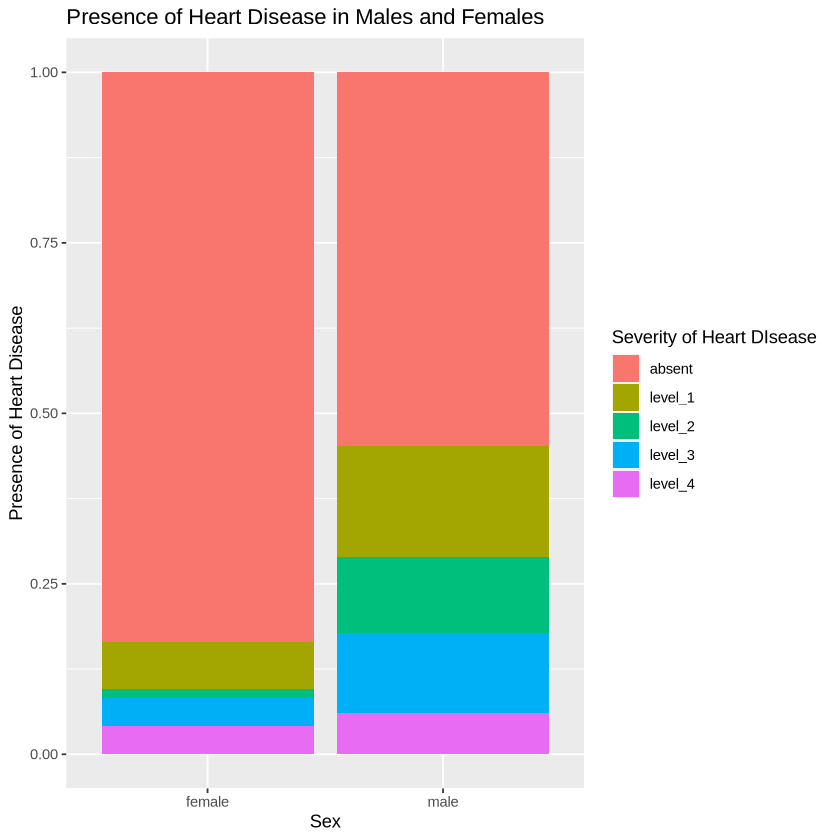

In [11]:
#create a visualization of the some of the data 
heart_disease_1<- select(heart_disease_final, sex, diagnosis)

heart_disease_1_plot <- heart_disease_1 |>
   ggplot(aes(x = sex, fill = diagnosis)) + 
   geom_bar(position = 'fill') + 
   xlab("Sex") +
   ylab("Presence of Heart Disease") +
   labs(fill = "Severity of Heart DIsease") +
   ggtitle("Presence of Heart Disease in Males and Females")

heart_disease_1_plot

## Methods

The variables we are using to predict heart disease severity in a patient include: 
- "sex": the sex of the patient (Categorical, no missing values),
- "chol": the serum cholesterol content in blood in mg/dl (Integer, some missing values denoted as -9),
- "trestbps": resting blood pressure (Integer, one missing value denoted as -9),
- "age": the age of the patient (Integer, no missing values). 
Diagnosis and sex were changed to factors (categorical variables).

We will visualize the results using a bar plot. We also will use scatter plots in order to use nearest neighbors prediction with a K-Nearest Neighbours model. 



## Expected Outcomes and Significance

Higher serum cholesterol restricts blood flow within the arteries while high blood pressure constricts and damages blood vessels (Santos et al., 2023). Therefore, there is likely a strong, positive relationship between high cholesterol and blood pressure as well as the severity of heart disease. Individuals with higher cholesterol and blood pressure are more likely to have a higher severity of heart disease. <br><br>
Our findings can help predict an individual's likelihood of becoming afflicted with a heart disease and its severity using only a few key variables. This could allow for a quicker estimation of how at risk a certain patient may be, so instead of running extensive tests for all cases, only the patients predicted with heart disease could be tested properly and treated accordingly. <br><br>
This study could lead to questions on the power of predictive models used for clinical use and if their implementation into standard procedure could be beneficial for more efficient treatment of patients. <br>





### Citations

(1) World Health Organization: WHO. (2020, December 9). The top 10 causes of death. https://www.who.int/en/news-room/fact-sheets/detail/the-top-10-causes-of-death


(2 )Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X

(3) Santos, C., Matharoo, A. S., Cueva, E., Amin, U., Ramos, A. D., Mann, N., Maheen, S., Butchireddy, J., Falki, V., Itrat, A., Rajkumar, N., & Haq, M. Z. U. (2023). The Influence of sex, age, and race on Coronary Artery Disease: A Narrative review. Cureus. https://doi.org/10.7759/cureus.47799